In [1]:
%load_ext autoreload
%autoreload 2

Dependencies

In [2]:
import pathlib as pb

# Environment
ROOT_PATH = pb.Path('..')
DATA_DIR_PATH = ROOT_PATH / 'data'
CACHE_DIR_PATH = ROOT_PATH / '.cache'
TRANSFORMERS_CACHE_DIR_PATH = CACHE_DIR_PATH / 'transformers'
DATASETS_CACHE_DIR_PATH = CACHE_DIR_PATH / 'datasets'
TEST_DATA_FILE = DATA_DIR_PATH / 'test_data.csv'
TRAIN_DATA_FILE = DATA_DIR_PATH / 'train_data.csv'
SUBMISSIONS_DIR_PATH = ROOT_PATH / 'submissions'

In [3]:
import os

os.environ['TRANSFORMERS_CACHE'] = str(TRANSFORMERS_CACHE_DIR_PATH)
os.environ['HF_DATASETS_CACHE'] = str(DATASETS_CACHE_DIR_PATH)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import torchdata
import torchtext
from torch import Tensor
from torch import nn
from torch import optim
from torch.utils.data import Subset, DataLoader, Dataset, WeightedRandomSampler
from torch import backends
import typing
import pathlib as pb
import os
import gc
from typing import List, Tuple, Dict, Set, Callable, Any
import random
import numpy as np
import pandas as pd
import platform
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score

/home/invokariman/Projects/git/nitro-lang-processing-2/.cache/pypoetry/virtualenvs/nitro-lang-processing-2-mFR9zZTH-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from utils import get_available_device, read_data, silence_warnings
from preprocess import BERTPreprocessor, MT5Preprocessor, RobertPreprocessor
from data import SexismDataset
from models import Args, Output, Ensemble, RoBertFlatClassModel, BertFlatClassModel, MT5FlatClassModel
from train import evaluate, train

Environment Setup

In [6]:
# Use available GPU
DEVICE: torch.device = get_available_device()

# Deterministic experiments
SEED = 61
random.seed(SEED)
np.random.seed(SEED)
np.random.RandomState(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

# Adjust package settings
silence_warnings()

Dataset & Preprocessing

In [7]:
# Load raw dataset
train_data_raw, test_data_raw = read_data(DATA_DIR_PATH)

# Initialize custom pretraiend preprocessor
preprocessor = RobertPreprocessor()

# Create and preprocess the datasets
train_dataset = SexismDataset(train_data_raw, preprocessor)
test_dataset = SexismDataset(test_data_raw, preprocessor)

In [8]:
train_dataset.weights, train_dataset.class_to_freq

(tensor([0.9444, 0.9613, 0.9944, 0.2106, 0.8893]),
 {0: tensor(0.0005),
  1: tensor(0.0007),
  2: tensor(0.0045),
  3: tensor(3.2438e-05),
  4: tensor(0.0002)})

Model Setup

In [9]:
# Keep the training setup separately
args = Args()
model_factory: Callable[[], nn.Module] = lambda: torch.compile(RoBertFlatClassModel()).to(DEVICE)
optim_factory: Callable[..., optim.Optimizer] = lambda params: optim.AdamW(params, lr=args.learning_rate, weight_decay=args.weight_decay)
loss_fn = nn.CrossEntropyLoss(weight=train_dataset.weights.to(DEVICE))

HyperParameter Tuning using K-Fold Cross-Validation

In [10]:
# Inspired from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
models: List[nn.Module] = []

for i, (train_idx, valid_idx) in enumerate(kf.split(train_dataset, train_dataset.classes)):
    print('K-FOLD: {}'.format(i))
    
    # Reinitialize the model
    model: nn.Module = model_factory()
    optimizer: optim.Optimizer = optim_factory(model.parameters())

    # Split the data
    train_subset = Subset(train_dataset, train_idx)
    valid_subset = Subset(train_dataset, valid_idx)

    # Inverse frequency count for random sampling
    inv_freq = torch.tensor(list(train_dataset.class_to_freq.get(int(t['label'])) for t in train_subset))

    # Create WeightedRandomSampler
    wrs = WeightedRandomSampler(inv_freq, len(train_subset), replacement=True)

    # Create the dataloaders
    train_loader = DataLoader(train_subset, args.batch_size, sampler=wrs)
    valid_loader = DataLoader(train_subset, args.batch_size)

    # --- Validation ---
    def validation_pass() -> None:
        # --- Validation ---
        valid_output: Output = evaluate(
            model=model,
            loss_fn=loss_fn,
            data_loader=valid_loader,
            with_labels=True,
            class_to_label=train_dataset.class_to_label,
            device=DEVICE
        )
        print('Validation - Loss: {}, Accuracy: {}'.format(valid_output.loss_mean, valid_output.accy_mean))

    # --- Training ---
    train_output: Output = train(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        data_loader=train_loader,
        class_to_label=train_dataset.class_to_label,
        args=args,
        device=DEVICE,
        valid_callback=validation_pass,
    )
    print('Last Epoch - Loss: {}, Accuracy: {}'.format(train_output.loss_mean, train_output.accy_mean))
    models.append(model)

K-FOLD: 0


Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 05:10:48,201] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.37907877564430237, Accuracy: 0.8076638265635194
Validation - Loss: 0.7541513442993164, Accuracy: 0.8504680025117323
Train Epoch 1 - Loss: 0.12262720614671707, Accuracy: 0.927834966693718
Validation - Loss: 0.39138221740722656, Accuracy: 0.9269170328672871
Train Epoch 2 - Loss: 0.07488896697759628, Accuracy: 0.954644969496556
Validation - Loss: 0.2906076908111572, Accuracy: 0.9543438383467815
Last Epoch - Loss: 0.07488896697759628, Accuracy: 0.954644969496556
K-FOLD: 1


Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 05:14:12,308] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.36746853590011597, Accuracy: 0.8092023994429317
Validation - Loss: 0.5265306234359741, Accuracy: 0.8888479597850806
Train Epoch 1 - Loss: 0.12394855916500092, Accuracy: 0.9250771357040548
Validation - Loss: 0.2795581817626953, Accuracy: 0.9469968380156746
Train Epoch 2 - Loss: 0.0714215636253357, Accuracy: 0.9573261392593532
Validation - Loss: 0.2557101249694824, Accuracy: 0.9576033332792567
Last Epoch - Loss: 0.0714215636253357, Accuracy: 0.9573261392593532
K-FOLD: 2


Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 05:17:33,125] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.36738917231559753, Accuracy: 0.8130452710033058
Validation - Loss: 0.5756785273551941, Accuracy: 0.8747990787406189
Train Epoch 1 - Loss: 0.12595921754837036, Accuracy: 0.9240661831629079
Validation - Loss: 0.30370232462882996, Accuracy: 0.9394628344144527
Train Epoch 2 - Loss: 0.07247365266084671, Accuracy: 0.9573483879932192
Validation - Loss: 0.30878087878227234, Accuracy: 0.9534650119518429
Last Epoch - Loss: 0.07247365266084671, Accuracy: 0.9573483879932192
K-FOLD: 3


Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 05:20:56,653] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.3622134327888489, Accuracy: 0.8076574646968712
Validation - Loss: 0.6207423806190491, Accuracy: 0.8729321141059828
Train Epoch 1 - Loss: 0.1228179931640625, Accuracy: 0.9249218346761849
Validation - Loss: 0.39753177762031555, Accuracy: 0.929282940485413
Train Epoch 2 - Loss: 0.07748803496360779, Accuracy: 0.9543481955892396
Validation - Loss: 0.25379422307014465, Accuracy: 0.9560811660197744
Last Epoch - Loss: 0.07748803496360779, Accuracy: 0.9543481955892396
K-FOLD: 4


Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 05:25:51,575] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.36008015275001526, Accuracy: 0.8144779474193496
Validation - Loss: 0.7480453848838806, Accuracy: 0.8413211572233013
Train Epoch 1 - Loss: 0.12754592299461365, Accuracy: 0.9254581398926334
Validation - Loss: 0.4362753927707672, Accuracy: 0.9184028295577581
Train Epoch 2 - Loss: 0.07474146038293839, Accuracy: 0.9563970703185135
Validation - Loss: 0.267004132270813, Accuracy: 0.9568531626736474
Last Epoch - Loss: 0.07474146038293839, Accuracy: 0.9563970703185135


In [11]:
majority = Ensemble(models)

Training on the Whole Dataset

In [ ]:
# Reinitialize the model
model: nn.Module = model_factory()
optimizer: optim.Optimizer = optim_factory(model.parameters())

# Create the dataloaders
train_loader = DataLoader(train_dataset, args.batch_size, shuffle=True)

# --- Training ---
train_output: Output = train(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    data_loader=train_loader,
    class_to_label=train_dataset.class_to_label,
    args=args,
    device=DEVICE,
)
print('Last Epoch - Loss: {}, Accuracy: {}'.format(train_output.loss_mean, train_output.accy_mean))

Prediction

In [17]:
test_loader: DataLoader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
test_output: Output = evaluate(
    model=majority,
    loss_fn=loss_fn,
    data_loader=test_loader,
    with_labels=False,
    class_to_label=train_dataset.class_to_label,
    device=DEVICE
)

<Axes: >

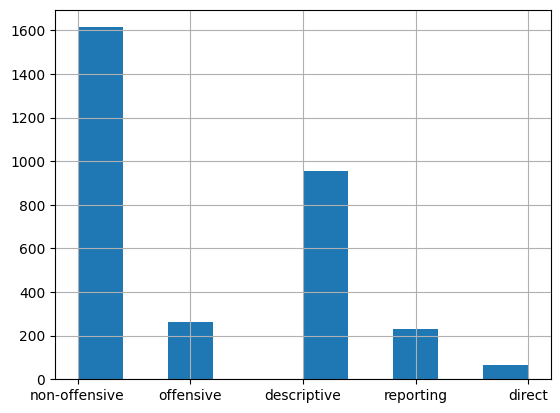

In [18]:
output: pd.DataFrame = pd.DataFrame({ 'Label': pd.Series(data=test_output.predictions_as_text) })
output = output.reset_index()
output = output.rename(columns={ 'index': 'Id' })
output.to_csv(SUBMISSIONS_DIR_PATH / 'submission_14.csv', index=False)
output['Label'].hist()

In [ ]:
# Free memory
# del model
# gc.collect()
# torch.cuda.empty_cache()